# Library and Configuration

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.fft
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import pandas as pd

In [2]:
BATCH_SIZE = 32
EPOCHS = 5     # Increased epochs for better convergence
LR = 0.001
DATA_DIR = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COMPARISON_LIST = [
    'alexnet', 'alexnet_asbw',
    'resnet18', 'resnet18_asbw',
]

print(f"Running on device: {DEVICE}")
print(f"Models to compare: {COMPARISON_LIST}")

Running on device: cuda
Models to compare: ['alexnet', 'alexnet_asbw', 'resnet18', 'resnet18_asbw']


# Model

In [3]:
class ASBW_DFT_Layer(nn.Module):
    """
    Adaptive Spectral-Band Weighting (ASBW) Layer.
    Uses DFT Magnitude to learn frequency-domain attention weights.
    """
    def __init__(self, channels, reduction=16):
        super(ASBW_DFT_Layer, self).__init__()
        # MLP to learn channel importance from spectral features
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, h, w = x.shape
        
        # 1. Compute 2D FFT
        fft = torch.fft.fft2(x)
        
        # 2. Compute Magnitude and apply Log scale (to compress dynamic range)
        mag = torch.abs(fft)
        mag = torch.log1p(mag)

        # 3. Global Average Pooling on Frequency Domain
        z = mag.mean(dim=[-2, -1]) 
        
        # 4. Learn weights via MLP
        w = self.mlp(z)
        w = w.view(b, c, 1, 1) # Reshape for broadcasting

        # 5. Reweight the input feature map
        return x * w

class ForensicResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ForensicResNet18, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.asbw1 = ASBW_DFT_Layer(64)
        self.asbw2 = ASBW_DFT_Layer(128)
        self.asbw3 = ASBW_DFT_Layer(256)
        self.asbw4 = ASBW_DFT_Layer(512)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        x = self.backbone.conv1(x); x = self.backbone.bn1(x); x = self.backbone.relu(x); x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x); x = self.asbw1(x)
        x = self.backbone.layer2(x); x = self.asbw2(x)
        x = self.backbone.layer3(x); x = self.asbw3(x)
        x = self.backbone.layer4(x); x = self.asbw4(x)
        x = self.backbone.avgpool(x); x = torch.flatten(x, 1); x = self.backbone.fc(x)
        return x

# --- 2. ALEXNET + ASBW ---
class ForensicAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ForensicAlexNet, self).__init__()
        original_model = models.alexnet(pretrained=True)
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        self.classifier = original_model.classifier
        
        self.classifier[6] = nn.Linear(4096, num_classes)

        self.asbw1 = ASBW_DFT_Layer(64)
        self.asbw2 = ASBW_DFT_Layer(192)
        self.asbw3 = ASBW_DFT_Layer(256)

    def forward(self, x):
        # Thủ công forward qua từng lớp để chèn ASBW
        f = self.features
        x = f[0](x); x = f[1](x); x = f[2](x) # Block 1
        x = self.asbw1(x)
        
        x = f[3](x); x = f[4](x); x = f[5](x) # Block 2
        x = self.asbw2(x)
        
        x = f[6](x); x = f[7](x)              # Block 3
        x = f[8](x); x = f[9](x)              # Block 4
        x = f[10](x); x = f[11](x); x = f[12](x) # Block 5
        x = self.asbw3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- 3. VGG16 + ASBW ---
class ForensicVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(ForensicVGG16, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier
        self.classifier[6] = nn.Linear(4096, num_classes)
        
        self.asbw1 = ASBW_DFT_Layer(64)
        self.asbw2 = ASBW_DFT_Layer(128)
        self.asbw3 = ASBW_DFT_Layer(256)
        self.asbw4 = ASBW_DFT_Layer(512)
        self.asbw5 = ASBW_DFT_Layer(512)

    def forward(self, x):
        f = self.features
        # Block 1
        x = f[0](x); x = f[1](x); x = f[2](x); x = f[3](x); x = f[4](x) 
        x = self.asbw1(x)
        # Block 2
        x = f[5](x); x = f[6](x); x = f[7](x); x = f[8](x); x = f[9](x)
        x = self.asbw2(x)
        # Block 3
        for i in range(10, 17): x = f[i](x)
        x = self.asbw3(x)
        # Block 4
        for i in range(17, 24): x = f[i](x)
        x = self.asbw4(x)
        # Block 5
        for i in range(24, 31): x = f[i](x)
        x = self.asbw5(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- 4. EFFICIENTNET-B0 + ASBW ---
class ForensicEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ForensicEfficientNet, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.asbw_mid = ASBW_DFT_Layer(80)
        self.asbw_high = ASBW_DFT_Layer(192)
        self.asbw_final = ASBW_DFT_Layer(320)

        self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, num_classes)

    def forward(self, x):
        f = self.backbone.features
        
        # Block 0-3
        for i in range(4): x = f[i](x)
        
        # Block 4 (Channel 80) -> ASBW
        x = f[4](x)
        x = self.asbw_mid(x)
        
        # Block 5-6 (Channel 112 -> 192)
        x = f[5](x); x = f[6](x)
        x = self.asbw_high(x)
        
        # Block 7-8
        x = f[7](x); x = f[8](x)
        x = self.asbw_final(x)
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        return x

# --- FACTORY FUNCTION ---
def get_model(model_name, num_classes, device):
    print(f">> Initializing {model_name}...")
    
    # --- PROPOSED MODELS (WITH ASBW) ---
    if model_name == 'resnet18_asbw':
        model = ForensicResNet18(num_classes)
    elif model_name == 'alexnet_asbw':
        model = ForensicAlexNet(num_classes)
    elif model_name == 'vgg16_asbw':
        model = ForensicVGG16(num_classes)
    elif model_name == 'efficientnet_b0_asbw':
        model = ForensicEfficientNet(num_classes)
        
    # --- BASELINE MODELS (WITHOUT ASBW) ---
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
        
    return model.to(device)

# Dataloader

In [4]:
def get_dataloaders(data_dir, batch_size=32):
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    test_dir  = os.path.join(data_dir, 'test')

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val_test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    try:
        train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
        valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['val_test'])
        test_dataset  = datasets.ImageFolder(test_dir,  transform=data_transforms['val_test'])
    except FileNotFoundError:
        print("Data path error!")
        return None, None, None, None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, valid_loader, test_loader, train_dataset.classes

# EDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.5730798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.6457081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.490453..1.6108497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47332823..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5161401..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
C


--- Performing EDA ---


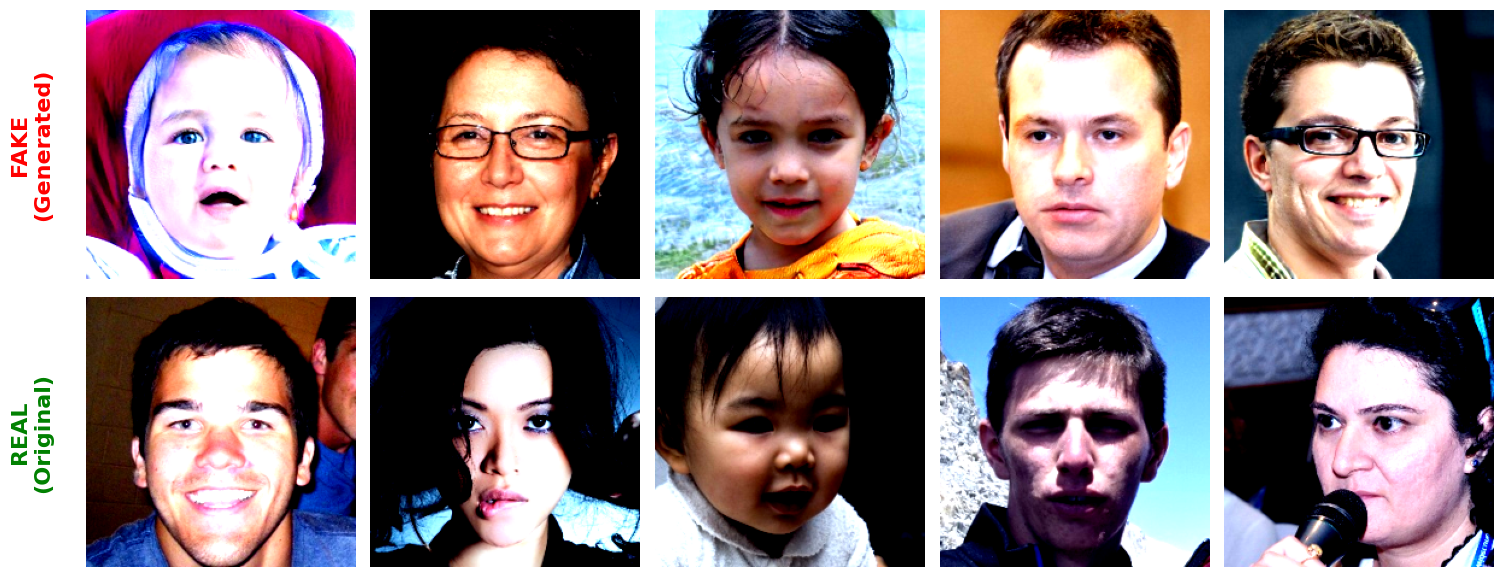

In [19]:
def visualize_eda(dataset):
    print("\n--- Performing EDA ---")

    class_to_idx = dataset.class_to_idx
    targets = np.array(dataset.targets)

    # Get indices for Real and Fake
    fake_idx_val = class_to_idx['fake']
    real_idx_val = class_to_idx['real']

    fake_indices = np.where(targets == fake_idx_val)[0]
    real_indices = np.where(targets == real_idx_val)[0]

    # Randomly select 5 images from each class
    selected_fake = np.random.choice(fake_indices, 5, replace=False)
    selected_real = np.random.choice(real_indices, 5, replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Plot Fake Images
    for i, idx in enumerate(selected_fake):
        img, label = dataset[idx]
        # Un-normalize for display: (img * std) + mean
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

    # Add label for the Fake row
    axes[0, 0].text(-0.2, 0.5, "FAKE\n(Generated)", transform=axes[0, 0].transAxes,
                    va='center', ha='center', fontsize=16, color='red', fontweight='bold', rotation=90)

    # Plot Real Images
    for i, idx in enumerate(selected_real):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[1, i].imshow(img)
        axes[1, i].axis('off')

    # Add label for the Real row
    axes[1, 0].text(-0.2, 0.5, "REAL\n(Original)", transform=axes[1, 0].transAxes,
                    va='center', ha='center', fontsize=16, color='green', fontweight='bold', rotation=90)

    plt.tight_layout()
    plt.show()

# Run EDA
train_loader, val_loader, test_loader, class_names = get_dataloaders(DATA_DIR, BATCH_SIZE)
if 'train_loader' in locals():
    visualize_eda(train_loader.dataset)

# Training and Evaluating

In [6]:
def train_and_evaluate(model_name, device):
    # Load Data
    train_loader, val_loader, test_loader, class_names = get_dataloaders(DATA_DIR, BATCH_SIZE)
    if not train_loader: return None
    
    # Model Setup
    model = get_model(model_name, len(class_names), device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Training Loop
    print(f"\n--- Training {model_name} ---")
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0; total = 0
        
        pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", unit="batch", leave=False)
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            current_loss = running_loss / (pbar.n + 1)
            current_acc = 100 * correct / total
            pbar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.2f}%")
            
        train_acc = 100 * correct / total
        print(f"Ep {epoch+1} Finished: Loss {running_loss/len(train_loader):.4f} | Acc {train_acc:.2f}%")

    model.eval()
    all_preds = []; all_labels = []
    
    print(f"Evaluating {model_name}...")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    torch.save(model.state_dict(), f"{model_name}.pth")
    return {
        'Model': model_name,
        'Base_Arch': model_name.replace('_asbw', ''),
        'Has_ASBW': 'Yes' if 'asbw' in model_name else 'No',
        'Accuracy': acc * 100,
        'F1-Score': f1 * 100
    }

# Main

In [7]:
results = []

for model_name in COMPARISON_LIST:
    res = train_and_evaluate(model_name, DEVICE)
    if res:
        results.append(res)
        print(f"Done {model_name}: Acc={res['Accuracy']:.2f}%")

>> Initializing alexnet...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 202MB/s] 



--- Training alexnet ---


Ep 1 Finished: Loss 0.6982 | Acc 49.89%


Ep 2 Finished: Loss 0.6934 | Acc 50.04%


Ep 3 Finished: Loss 0.6934 | Acc 50.31%


Ep 4 Finished: Loss 0.6933 | Acc 49.64%


Ep 5 Finished: Loss 0.6933 | Acc 50.10%
Evaluating alexnet...


Testing: 100%|██████████| 625/625 [01:24<00:00,  7.40batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done alexnet: Acc=50.00%
>> Initializing alexnet_asbw...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Training alexnet_asbw ---


Ep 1 Finished: Loss 0.6947 | Acc 50.11%


Ep 2 Finished: Loss 0.6934 | Acc 49.85%


Ep 3 Finished: Loss 0.6934 | Acc 50.06%


Ep 4 Finished: Loss 0.6934 | Acc 49.90%


Ep 5 Finished: Loss 0.6933 | Acc 50.18%
Evaluating alexnet_asbw...


Testing: 100%|██████████| 625/625 [00:47<00:00, 13.27batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done alexnet_asbw: Acc=50.00%
>> Initializing resnet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]



--- Training resnet18 ---


Ep 1 Finished: Loss 0.1905 | Acc 92.11%


Ep 2 Finished: Loss 0.0793 | Acc 97.08%


Ep 3 Finished: Loss 0.0554 | Acc 97.98%


Ep 4 Finished: Loss 0.0427 | Acc 98.46%


Ep 5 Finished: Loss 0.0355 | Acc 98.75%
Evaluating resnet18...


Testing: 100%|██████████| 625/625 [01:15<00:00,  8.28batch/s]


Done resnet18: Acc=97.61%
>> Initializing resnet18_asbw...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Training resnet18_asbw ---


Ep 1 Finished: Loss 0.1983 | Acc 91.71%


Ep 2 Finished: Loss 0.0787 | Acc 97.08%


Ep 3 Finished: Loss 0.0529 | Acc 98.03%


Ep 4 Finished: Loss 0.0404 | Acc 98.50%


Ep 5 Finished: Loss 0.0342 | Acc 98.77%
Evaluating resnet18_asbw...


Testing: 100%|██████████| 625/625 [00:48<00:00, 12.82batch/s]


Done resnet18_asbw: Acc=98.72%


NameError: name 'pd' is not defined

In [10]:
df = pd.DataFrame(results)
print("\nFinal Results Table:")
print(df)


Final Results Table:
           Model Base_Arch Has_ASBW  Accuracy   F1-Score
0        alexnet   alexnet       No     50.00  33.333333
1   alexnet_asbw   alexnet      Yes     50.00  33.333333
2       resnet18  resnet18       No     97.61  97.609992
3  resnet18_asbw  resnet18      Yes     98.72  98.719980


In [11]:
!wget https://imgs.search.brave.com/7Fk-j44XCS6vA7YsUUXQWHXeVHeaBlzPfFqKvB0HPhE/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5pc3RvY2twaG90/by5jb20vaWQvMTUz/MTc3MTE5L3Bob3Rv/L2FtZXJpY2FuLXNo/b3J0aGFpci1jYXQt/aW4tYS1iZWF1dGlm/dWwtYW5kLWNsZWFu/LWJhY2tncm91bmQu/anBnP3M9NjEyeDYx/MiZ3PTAmaz0yMCZj/PTJGX1JOT0N6OWxE/aExQVFZ2OG9GRTM2/dER5ZDUzTU5nZDFG/NEtsbzNQbzA9 -O cat.png

--2025-12-24 16:59:58--  https://imgs.search.brave.com/7Fk-j44XCS6vA7YsUUXQWHXeVHeaBlzPfFqKvB0HPhE/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5pc3RvY2twaG90/by5jb20vaWQvMTUz/MTc3MTE5L3Bob3Rv/L2FtZXJpY2FuLXNo/b3J0aGFpci1jYXQt/aW4tYS1iZWF1dGlm/dWwtYW5kLWNsZWFu/LWJhY2tncm91bmQu/anBnP3M9NjEyeDYx/MiZ3PTAmaz0yMCZj/PTJGX1JOT0N6OWxE/aExQVFZ2OG9GRTM2/dER5ZDUzTU5nZDFG/NEtsbzNQbzA9
Resolving imgs.search.brave.com (imgs.search.brave.com)... 18.238.238.44, 18.238.238.79, 18.238.238.125, ...
Connecting to imgs.search.brave.com (imgs.search.brave.com)|18.238.238.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34997 (34K) [image/jpeg]
Saving to: ‘cat.png’

cat.png             100%[===================>]  34.18K  --.-KB/s    in 0.007s  

2025-12-24 16:59:58 (4.89 MB/s) - ‘cat.png’ saved [34997/34997]



In [16]:
from PIL import Image
import torch
from torchvision import transforms

infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(image_path, model, device, class_names):
    img = Image.open(image_path).convert("RGB")
    img = infer_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    return class_names[pred], probs[0][pred].item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ForensicResNet18(num_classes=2)
model.load_state_dict(
    torch.load("resnet18_asbw.pth", map_location=device)
)
model = model.to(device)
model.eval()

class_names = ["real", "fake"]
label, confidence = predict_image("cat.png", model, device, class_names)
print(label, confidence)


fake 0.9982080459594727
